In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import syft as sy
hook=sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/root/anaconda3/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0.so'


### Creating two clients and fitting a linear regression made with a neural network

In [2]:
#torch.rand => uniform distribution

dim=100

X1=torch.rand(dim, 1) 
X2=torch.rand(dim,1)

a_1,b_1=5,-1
a_2,b_2=4,-1.2
y1=a_1*X1+b_1+0.5*torch.randn(dim,1)
y2=a_2*X2+b_2+0.5*torch.randn(dim,1)

### FedAvg for the two clients created above

In [3]:
#Create the server and the clients
server = sy.VirtualWorker(hook, id="server")
C1 = sy.VirtualWorker(hook, id="C1")
C2 = sy.VirtualWorker(hook, id="C2")

#Send the features and the labels to its associated client
C1_x = X1.send(C1)
C1_y = y1.send(C1)

C2_x = X2.send(C2)
C2_y = y2.send(C2)

In [4]:
#metrics we are interested in
C1_loss_hist=[]
C2_loss_hist=[]
S_loss_hist=[]
C1_a=[]
C1_b=[]
C2_a=[]
C2_b=[]
S_a=[]
S_b=[]

#torch model used for the inference
model = nn.Linear(1,1)

loss_f=nn.MSELoss()
iterations=100
epochs=5
precision=100
epsilon =10**-10
iter_max=1000
i=0

#print(model.weight.data.numpy(),model.bias.data.numpy())

while precision>epsilon and i<iter_max:
    C1_model = model.copy().send(C1)
    C2_model = model.copy().send(C2)
    
    C1_opt = optim.SGD(params=C1_model.parameters(),lr=0.1)
    C2_opt = optim.SGD(params=C2_model.parameters(),lr=0.1)
    
    for j in range(epochs):
        
        # Train Bob's Model
        C1_opt.zero_grad()
        C1_pred = C1_model(C1_x)
        C1_loss = loss_f(C1_pred,C1_y)
        C1_loss.backward()

        C1_opt.step()
        C1_loss = C1_loss.get().data
                
        # Train Alice's Model
        C2_opt.zero_grad()
        C2_pred = C2_model(C2_x)
        C2_loss = loss_f(C2_pred,C2_y)
        C2_loss.backward()

        C2_opt.step()
        C2_loss = C2_loss.get().data
    
    C1_loss_hist+=[C1_loss.numpy()]
    C2_loss_hist+=[C2_loss.numpy()]
    S_loss_hist+=[(C1_loss.numpy()+C2_loss.numpy())/2]
    
    try:precision=(S_loss_hist[-1]-S_loss_hist[-2])**2
    except:pass
    
    C1_model.move(server)
    C2_model.move(server)

    with torch.no_grad():
        
        C1_weight=C1_model.weight.get().data
        C2_weight=C2_model.weight.get().data
        
        C1_bias=C1_model.bias.get().data
        C2_bias=C2_model.bias.get().data
        
        C1_a+=[np.reshape(C1_weight.numpy(),1)]
        C1_b+=[C1_bias.numpy()]
        
        C2_a+=[np.reshape(C2_weight.numpy(),1)]
        C2_b+=[C2_bias.numpy()]        
        
        new_weight=((C1_weight.data + C2_weight.data) / 2)
        new_bias=((C1_bias.data + C2_bias.data) / 2)
        
        S_a+=[np.reshape(new_weight.numpy(),1)]
        S_b+=[new_bias.numpy()]
        
        model.weight.set_(new_weight)
        model.bias.set_(new_bias)
    
    if i%10==0:
        print("iteration "+str(i))
        print(model.weight.data.numpy(),model.bias.data.numpy())
        print("C1:" + str(C1_loss.detach().numpy()) + " C2:" + str(C2_loss.detach().numpy()))
        print(precision)
    
    i+=1

iteration 0
[[1.0438594]] [0.8260523]
C1:1.7389777 C2:1.3064018
100
iteration 10
[[2.868792]] [-0.19803664]
C1:0.6943027 C2:0.47412813
0.0018694253442532727
iteration 20
[[3.719811]] [-0.6893896]
C1:0.4419825 C2:0.3137125
9.057355598329764e-05
iteration 30
[[4.119471]] [-0.9201411]
C1:0.37494975 C2:0.28997144
4.368503269347457e-06
iteration 40
[[4.307161]] [-1.0285077]
C1:0.35481948 C2:0.2902009
2.0878430007087445e-07
iteration 50
[[4.395305]] [-1.0793993]
C1:0.3478691 C2:0.2928183
9.772173292788011e-09
iteration 60
[[4.436699]] [-1.1032993]
C1:0.34515724 C2:0.294601
4.3520742565306136e-10


In [5]:
new_weight.numpy()

array([[4.4482336]], dtype=float32)

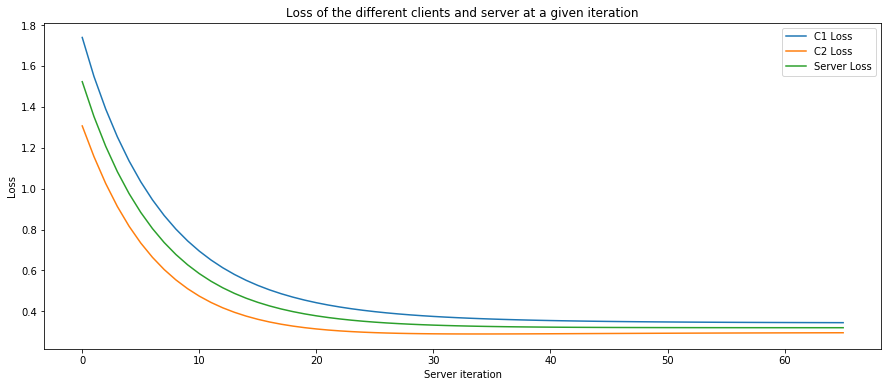

In [6]:
plt.figure(figsize=(15,6))
plt.plot(C1_loss_hist,label="C1 Loss")
plt.plot(C2_loss_hist,label="C2 Loss")
plt.plot(S_loss_hist,label="Server Loss")
plt.title("Loss of the different clients and server at a given iteration")
plt.xlabel("Server iteration")
plt.ylabel("Loss")
plt.legend()

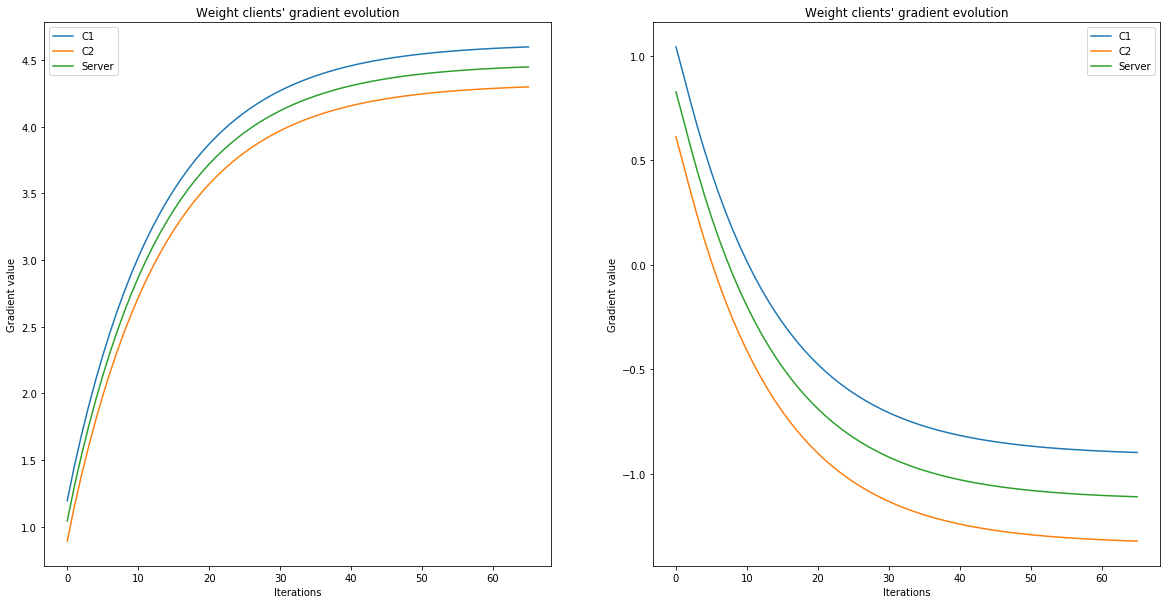

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(C1_a,label="C1")
plt.plot(C2_a,label="C2")
plt.plot(S_a,label="Server")
plt.title("Weight clients' gradient evolution")
plt.xlabel("Iterations")
plt.ylabel("Weight value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(C1_b,label="C1")
plt.plot(C2_b,label="C2")
plt.plot(S_b,label="Server")
plt.title("Weight clients' gradient evolution")
plt.xlabel("Iterations")
plt.ylabel("Bias Value")
plt.legend()

Text(0.5, 0, 'Gradient Bias Client 2')

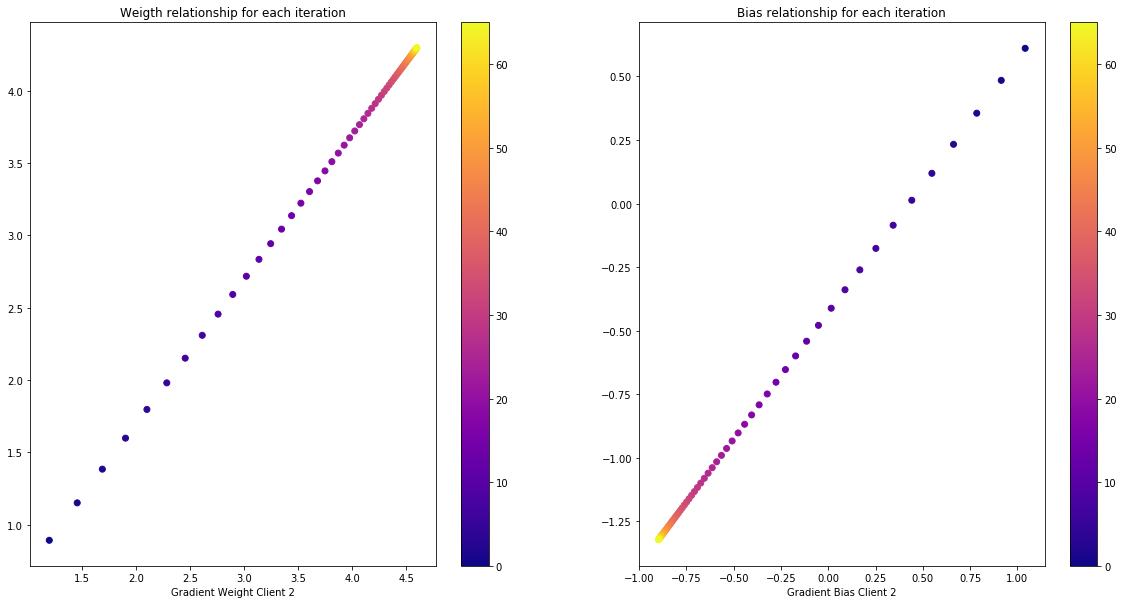

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("Weigth relationship for each iteration")
plt.scatter(C1_a,C2_a,c=[[i] for i in range(len(C1_a))],cmap='plasma')
plt.colorbar()
plt.xlabel("Gradient Weight Client 1")
plt.xlabel("Gradient Weight Client 2")

plt.subplot(1,2,2)
plt.title("Bias relationship for each iteration")
plt.scatter(C1_b,C2_b,c=[[i] for i in range(len(C1_a))],cmap='plasma')
plt.colorbar()
plt.xlabel("Gradient Bias Client 1")
plt.xlabel("Gradient Bias Client 2")